# **Medical Semantic Segmentation**

## **Objective -  Determines the region of the disease looking at the 3D medical image provided**

#### Medical Image Segmentation is the process of automatic or semi-automatic detection of boundaries within a 2D or 3D image.

#### In this notebook, I've made use of the U-Net architecture to identify cancer regions in Colon MRI scans of patients.
#### The Data for the task is obtained from http://medicaldecathlon.com/.
#### About the data :
*1.Target: Colon Cancer Primaries*

*2.Modality: CT*

*3.Size: 190 3D volumes (126 Training + 64 Testing)*


## Data

The data from the source was available as a tar file.We extract it into *.ni.gz* using the following :

```
with tarfile.open(os.path.join(os.getcwd(),'Task10_Colon.tar'),'r') as tar:
  tar.extractall()
```

The data is now available to us in **NifTi** format here. The NifTi (Neuroimaging Informatics Technology Initiative) is an open file format commonly used to store colon imaging data obtained using Computed tomography methods. There is a Python packaged called **nibabel** that we use to deal with this kind of data.

The dataset we use consists of 190 medical examinations in 3D which includes the source image scans as well as the masks of segmentation of the colon for each scan.

To carry out the task,we will be augmenting the data by converting 3D images to 2D images.To do so we make use of axial 2D slices.In essence we transform the 3D data into 2D cuts.


## Training 

The dataset was first divided into two subsets, train, and test. The  train set contains 50 images(Haven't utilized the entire dataset because of memory constraints) in which 90% were used for training and 10% for validation. 

During training, 50  ground truth segmentations were used to train the network to recognize the cancer regions. 

The model was trained for **20 epochs.**

After 20 epochs, calculated accuracy (Dice Coeffecient) was about **0.88 on the train set** and **0.9236 on the validation set.**

We made use of the **U-Net** architecture for this task.The principle of this architecture is to add to a usual contracting network layers with upsampling operators instead of pooling.
This allow the network to learn context (contracting path), then localization (expansive path). Context information is propagated to higher resolution layers thanks to skip-connexions. So we have images of the same size as the initial input.The original paper uses SGD as the optimizer but it turns out that Adam works out better for segmentation tasks.


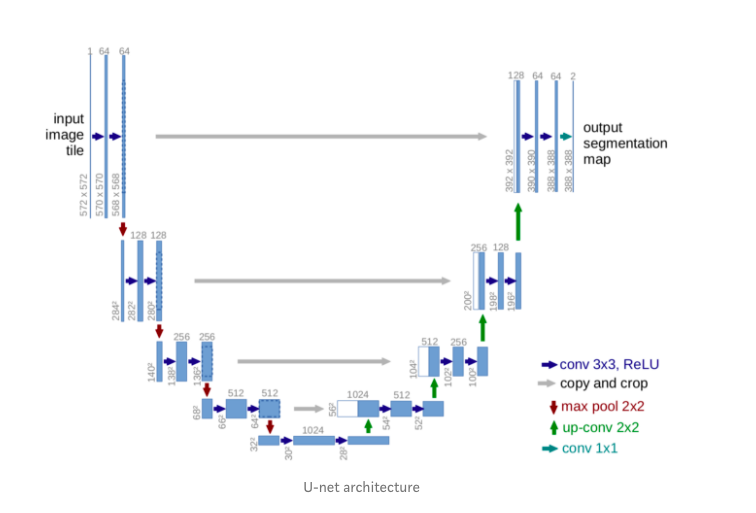

```
epoch = 20
batch_size = 32

model_checkpoint = ModelCheckpoint('weights.h5', monitor='val_loss', save_best_only=True)

history = model.fit(x = x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[2] ,1)),
                    y = y_train.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2] ,1)),
                    batch_size=batch_size, epochs = epoch,
                    validation_split=0.1,
                    callbacks=[model_checkpoint],verbose=1)
```



To indicate the model's performance, we make use of **Dice Coefficient.**Alternate to it is **Intersection Over Union Area(IOU)**.We can opt for any since both are positively correlated.
Dice Coefficient is essentially a measure of overlap between two samples. This measure ranges from 0 to 1 where a Dice coefficient of 1 denotes perfect and complete overlap.

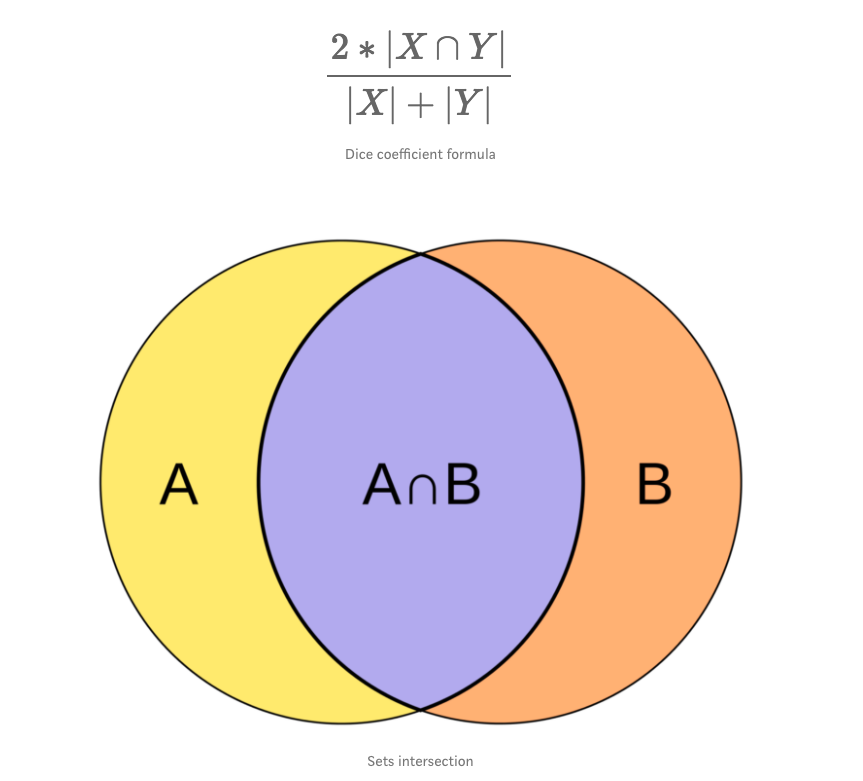

## Results

Dice Score Vs Epochs

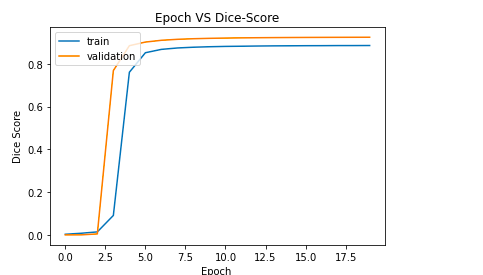


Loss Vs Epochs

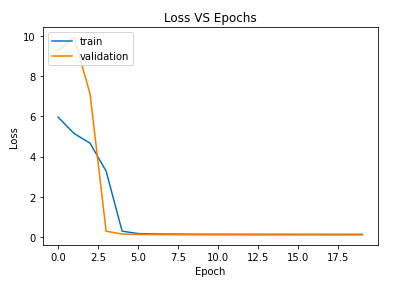

## Model Latency

To determine how quickly or slowly our model is inferencing, we need to check the latency of the model.If the model does not perform according to our standards we may optimize the model into a TFLite Model.



```
from datetime import datetime

elapsed_time = 0
s = datetime.now().time()
print(s)
pred_zero = model_loaded.predict(x_test.reshape((x_test.shape[0], x_test.shape[1], x_test.shape[2] ,1)))

e = datetime.now().time()
print(e)
# only interested on the time part, not the date
start_time = datetime.strptime(str(s), '%H:%M:%S.%f')

end_time = datetime.strptime(str(e), '%H:%M:%S.%f')

diff = end_time - start_time
elapsed_time = int((diff.seconds * 1000) + (diff.microseconds / 1000))
```



The forward pass takes roughly 1000ms hence we convert our model to TFLite model.



```
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

image = nib.load('/content/gdrive/My Drive/Capstone/Task10_Colon/imagesTr/colon_102.nii.gz')

# Test model on random input data.
s = datetime.now().time()
input_shape = input_details[0]['shape']
input_data = np.array(x_test[0].reshape(1,512,512,1), dtype=np.float32)
interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()

elapsed_time = 0

#print(s)
output_data = interpreter.get_tensor(output_details[0]['index'])
#print(output_data)

e = datetime.now().time()
#print(e)
# only interested on the time part, not the date
start_time = datetime.strptime(str(s), '%H:%M:%S.%f')

end_time = datetime.strptime(str(e), '%H:%M:%S.%f')

diff = end_time - start_time
elapsed_time = int((diff.seconds * 1000) + (diff.microseconds / 1000))
```



Using TFLite model, our foward pass time reduces down drastically to 311ms

## **Conclusion**
### **Successfully trained a neural network using U-Net architecture with a Dice coefficient that reaches almost ~0.92**

